Viewing the Jupyter Notebooks from nbviewer is encouraged because GitHub is still not fully integrated with the Jupyter Notebook:
http://nbviewer.jupyter.org/github/suyunu/TSPs-with-Profit/blob/master/ts-tspp.ipynb

# Tabu Search on Travelling Salesperson Problems with Profits

In this project, we tried to solve Travelling Salesperson Problems with Profits (TSPs with profits) with Tabu Search (TS). Before I start doing anything on the problem, I made a literature survey. There are lots of papers in the literature about TSPs with profits but those papers are generally tries to solve it with some constraints. So actually I couldn't find a good paper to pointing out our problem which has no constraint. But the following paper has some good ideas about the general structer of the problem even it has a constraint on the tour length:
* Gendreau, Michel, Gilbert Laporte, and Frédéric Semet. "A tabu search heuristic for the undirected selective travelling salesman problem." European Journal of Operational Research 106.2-3 (1998): 539-545.

## Travelling Salesperson Problems with Profits

Traveling Salesperson problems with profits (TSPs with profits) are a generalization of the traveling salesman problem (TSP), where it is not necessary to visit all vertices. A profit is associated with each vertex. The overall goal is the simultaneous optimization of the collected profit and the travel costs.
(http://pubsonline.informs.org/doi/abs/10.1287/trsc.1030.0079?journalCode=trsc)

## Solution Representation

I used a simple permutation representation. The list [1, 2, 3, 4, 5, 1] represents the route of the salesperson. All the routes should start with "1" and end with "1" which is the depot.

## Tabu Search

In this part I will explain the steps of tabu search for the travelling salesperson problems with profits.

### Pseudocode

<ol>
<li> **(Initialization)** Construct an initial tour by means of a construction heuristic.  </li>
<li> **(Insertion Partitions)** Determine all insertion partitions according to proximity measure and retain 10 of them. </li>
Repeat Step **3-8** for *$10000$* iterations:
<li> **(Insertion Candidate)** Randomly choose one insertion partition and determine the best insertion candidate from this partition </li>
<li> **(Deletion Chains)** Determine the deletion chains. </li>
<li> **(Deletion Candidate)** Determine the best deletion candidate from deletion chains </li>
<li> **(Insertion or Deletion)** Compare the results of the insertion and deletion then apply the best one. If the best move is deletion then declare all vertices of deletion tabu for $\theta$ iteration </li>
<li> **(Tour Improvement)** If the iteration count is multiple of 5, apply 2-opt </li>
<li> **(Best Solution Update)** If newly generated solution has a better objective then the incumbent solution then apply 3-opt to the newly generated solution to improve the tour quality and make it the incumbent solution. </li>
<li> **(Shuffle to Reset)** If there hasn't been an improvement in $\gamma$ iteration, then assign incumbent solution to the current solution and shuffle the route. Also clear the tabu list. </li>
</ol>




### Initialization

<ol>
<li> Determine a tour length $V$ and start building a tour </li>
Until length of route T reaches V, repeat:
<li> Randomly determine a spot $j$ in the tour $T$ and add the city $v_j \not \in T$ having the minimal ratio $ (d_{ij} + d_{jk} - d_{ik}) / p_j$</li>
<li> Apply 2-opt to the generated list </li>
</ol>

After lots of test initial tour length $V = N/2$ gave the best results. So function runs 5 time and constructs 5 route with length $N/2$, then chooses the route with best objective.

### Insertion Partitions

#### Dispersion Index

Dispersion index of a non-emty list R,

$$
\Gamma(R) =
\begin{cases}
   \frac{1}{|R|(|R|-1)} \sum_{v_i, v_j \in R}{d_{ij}}    & \quad \text{if } |R| > 1 \\
   0 & \quad \text{if } |R| = 1\\
\end{cases}
$$

#### Proximity Measure
Proximity measure between two non-empty lists R and S,

$$
\Delta(R, S) = \frac{2}{|R||S|} \left(\sum_{v_i \in R, v_j \in S}{d_{ij}}\right) - \Gamma(R) - \Gamma(S)
$$

Note that, if $R = \{v_i\}$ and $S = \{v_j\}$, then $\Delta(R, S) = d_{ij}$

#### Procedure

Using this proximity measure, we define several partitions of $V \setminus \{v_0\}$ within a preprocessing step of the algorithm. Each of these partitions contains clusters of vertices

<ol>
<li> **(First Partition)** Set $r:= 1$ and $P_r := \{\{v_1\}, \dots, \{v_n\}\}$ </li>
<li> **(Next Partitions)** If $r = N$ stop. Otherwise, define $P_{r+1}$ form $P_r$ by merging the two clusters $C_{ri^*}$ and $C_{rk^*}$ of $P_r$ yielding $min_{i \not = j}\{\Delta(C_{ri}, C_{rk})\}$ set $r := r + 1$ and repeat this step. </li>
</ol>

We calculate all possible $N-1$ partitions but we only retain partitions $P_r$ corresponding to $r = \{1, int(N/2), int(2*N/3), int(3*N/4), int(4*N/5), int(5*N/6), int(6*N/7), int(7*N/8), int(8*N/9), int(9*N/10)\}$ at the begining. One reason for keeping at most 10 partitions is to save memory. Moreover, removing partitions that are very similar to one another will create a diversification effect in the search process. This will become clearer later on.

### Insertion Candidates

The value of insertion of a cluster $C'_{rk}$ from the partition $P_r$ is measured by the ratio of added profit over added distance.

The gravity centre $\bar v_k$ of $C'_{rk}$ is first computed for all clusters of $P_r$, and a preliminary move evaluation is made according to the formula

$$
\bar g(C'_{sk}) = \frac{\sum_{v_h \in C'_{sk}}{p_h}}{l(T \cup \{\bar v_k\}) - l(T)}
$$

The cluster $C'_{{sk}^*}$ corresponding to $max_k\{\bar g(C'_{sk})\}$ is then selected. The exact move evaluation associated with $C'_{{sk}^*}$ is

$$
\bar g(C'_{{sk}^*}) = \frac{\sum_{v_h \in C'_{{sk}^*}}{p_h}}{l(T \cup C'_{{sk}^*}) - l(T)}
$$


### Deletion Chains

The sets of vertices $H_{ij}$ candidate for removal are defined as follows. Consider a solution $ T = \{v_0, \dots, v_{j_0}, v_{i_1}, \dots, v_{j_1}, v_{i_2}, \dots, v_{j_{\lambda-1}}, v_{i_0}, \dots, v_{0}\} $ are the $\lambda$ longest edges of the tour and $\lambda$ is an input parameter randomly selected in the interval $[2, \delta/2]$, and $\delta$ is the maximum between 4 and the number of vertices appearing on the initial tour. Then the sets $H_{ij}$ are simply $ H_{i_1 j_1}, \dots, H_{i_{\lambda-1} j_{\lambda-1}}$

### Deletion Candidates

The value of a move associated with the removal of a chain $H_{ij}$ is measured by the ratio of saved distance over lost profit, and is computed as

$$
f(H_{ij}) = \frac{l(T) - l(T \setminus H_{ij})}{\sum_{v_k \in H_{ij}}{p_k}}
$$

### Insertion or Deletion

Compare the results of the insertion and deletion then apply the best one. If the best move is deletion then declare all vertices of deletion tabu for $\theta$ iteration where $\theta$ is a random number between $(5, 25)$




### Tour Improvement

If the iteration count is the multiple of 5, apply 2-opt.

#### 2-opt

The main idea behind it is to take a route that crosses over itself and reorder it so that it does not. To speed up the 2-opt while comparing the new route to the old one, we just compare the added and repoved edges length.Also, at each iteration of 2-opt we are searching for the best update move and apply it.


### Best Solution Update

If newly generated solution has a better objective then the incumbent solution then apply 3-opt to the newly generated solution to improve the tour quality and make it the incumbent solution. 

#### 3-opt

3-opt analysis involves deleting 3 edges in a tour, reconnecting the tour in all other possible ways, and then evaluating each reconnection method to find the optimum one. This process is then repeated for all different set of 3 connections. To speed up 3-opt process, unlike our 2-opt implementation, we don't search for the best move in all the edge pairs, but we take the first move that results in a better tour. To make things stochastic, we select edges randomly.

### Shuffle to Reset

If there hasn't been an improvement in $\gamma$ iteration, then assign incumbent solution to the current solution and shuffle the route. Also clear the tabu list.




## Failed Extensions

We have also tried some other extensions to the tabu search to improve the results. However some of them just failed.

### Intermediate-Term Memory

Intensification rules intended to bias the search towards promising areas of the search space. If a node is always showing up in the solution then we made this node forbid to be in tabu list.

### Long-Term Memory 

Diversification rules that drive the search into new regions. If a node is always showing up in the solution then we made this node forbid to enter into the solutions for a longer time than a normal tabu.

### Shuffling

After completion of tabu search heuristic, to try to make an improvement in the route length, we shuffle and optimize the route several times.

## Extra - Visualization of 2-Opt

I have added an extra property to my 2-opt function. You can track the edge changes in the 2-opt algorithm visually by changing sending the function some parameters.

### Importing required libraries

In [2]:
import numpy as np
import math
import time
import random
import itertools
import queue
import pandas as pd
from IPython.display import display, Markdown
import networkx as nx
import matplotlib.pyplot as plt

### Reading data
Reading input from document and initializing variables.
You can change dataset by changing variable **dataset** to *'HP'* or *'LP'* and variable **N** to *51*, *76* or *101*.

In [8]:
# HP or LP
dataset = "HP"
# 51, 76 or 101
N = 51

filename = "dataset-" + dataset + ".xls"
df = pd.read_excel(filename, sheetname = "eil"+str(N), header = None, index_col = 0)

df.columns = ['x', 'y', 'prof']

display(df[0:10])

distances = [-1]
prof = [-1]

for lab, row in df.iterrows():
    tempDist = [-1]
    prof.append(row['prof'])
    for lab2, row2 in df.iterrows():
        dist = math.sqrt( math.pow(row['x']-row2['x'], 2) + math.pow(row['y']-row2['y'], 2) )
        tempDist.append(dist)
    distances.append(tempDist)
    
# dff holds the main data as given from the xls
# Started the indices from 1
dff = [[0,0,0]]
for lab, row in df.iterrows():
    dff.append([row['x'],row['y'],row['prof']])

,x,y,prof
0,,,
1,37,52,0
2,49,49,27
3,52,64,31
4,20,26,26
5,40,30,17
6,21,47,18
7,17,63,32
8,31,62,29
9,52,33,20


### Tabu Search Functions

In [27]:
def calculateObj(route):
    if len(route) == 0:
        return -99999999
    
    objVal = 0
    
    for i in range(1,len(route)):
        objVal = objVal + dff[route[i]][2] - distances[route[i-1]][route[i]]
        
    return objVal

def calculateTour(route):
    objVal = 0
    
    for i in range(1,len(route)):
        objVal = objVal + distances[route[i-1]][route[i]]
        
    return objVal


def updateGraph(G, old_route, route, se, visualize):
    G.remove_edge(old_route[se[0]-1], old_route[se[0]])
    G.remove_edge(old_route[se[1]], old_route[se[1]+1])
    G.add_edge(route[se[0]-1], route[se[0]])
    G.add_edge(route[se[1]], route[se[1]+1])
    if visualize:
        nx.draw(G,pos,with_labels = True)
        plt.show()
        print(str(old_route[se[0]-1]) + ',' + str(old_route[se[0]]) + ' - ' + str(old_route[se[1]]) + ',' + str(old_route[se[1]+1]))
    return G

def twoOpt(route, G=None, visualize = False):
    if G != None:
        pos=nx.get_node_attributes(G,'pos')
    if visualize and G != None:
        nx.draw(G,pos,with_labels = True)
        plt.show()
    se = (0,0)
    xx = 0
    while(True):
        xx = xx + 1
        temp_route = list(route)
        old_route = list(route)
        route_distance = -999999999
        for i in range(1, len(route)-2):
            for j in range(i+1, len(route)-1):
                new_route = route[:i] + list(reversed(route[i:j+1])) + route[j+1:]
                diff_distance = distances[route[i-1]][route[i]] + distances[route[j]][route[j+1]] 
                diff_distance = diff_distance - distances[new_route[i-1]][new_route[i]] - distances[new_route[j]][new_route[j+1]] 
                if diff_distance > route_distance:
                    temp_route = list(new_route)
                    route_distance = diff_distance
                    se = (i,j)
        if route_distance > 0.01:
            route = list(temp_route)
            if G != None:
                G = updateGraph(G, old_route, route, se, visualize)
        else:
            break
    return route, G

def threeOptSwap(route, i, j, k):
    bestRoute = list(route)
    best_diff = 0
    
    a = i
    b = j+1
    c = k+2
    
    nRoute = route[:a] + list(reversed(route[a:b])) + list(reversed(route[b:c])) + route[c:]
    diff = distances[route[a-1]][route[a]] + distances[route[b-1]][route[b]] + distances[route[c-1]][route[c]]
    diff = diff - distances[route[a-1]][route[b-1]] - distances[route[a]][route[c-1]] - distances[route[b]][route[c]]
    if diff > best_diff:
        best_diff = diff
        bestRoute = list(nRoute)
        
    nRoute = route[:a] + route[b:c] + route[a:b] + route[c:]
    diff = distances[route[a-1]][route[a]] + distances[route[b-1]][route[b]] + distances[route[c-1]][route[c]]
    diff = diff - distances[route[a-1]][route[b]] - distances[route[c-1]][route[a]] - distances[route[b-1]][route[c]]
    if diff > best_diff:
        best_diff = diff
        bestRoute = list(nRoute)
        
    nRoute = route[:a] + route[b:c] + list(reversed(route[a:b])) + route[c:]
    diff = distances[route[a-1]][route[a]] + distances[route[b-1]][route[b]] + distances[route[c-1]][route[c]]
    diff = diff - distances[route[a-1]][route[b]] - distances[route[c-1]][route[b-1]] - distances[route[a]][route[c]]
    if diff > best_diff:
        best_diff = diff
        bestRoute = list(nRoute)
        
    nRoute = route[:a] + list(reversed(route[b:c])) + route[a:b] + route[c:]
    diff = distances[route[a-1]][route[a]] + distances[route[b-1]][route[b]] + distances[route[c-1]][route[c]]
    diff = diff - distances[route[a-1]][route[c-1]] - distances[route[b]][route[a]] - distances[route[b-1]][route[c]]
    if diff > best_diff:
        best_diff = diff
        bestRoute = list(nRoute)
        
    return bestRoute, best_diff


def threeOpt(route):
    xx = 0
    while(True):
        xx += 1
        temp_route = list(route)
        old_route = list(route)
        best_diff = 0.01
        brk = False
        li = list(range(1, len(route)-2))
        random.shuffle(li)
        for i in li:
            lj = list(range(i, len(route)-2))
            random.shuffle(lj)
            for j in lj:
                lk = list(range(j, len(route)-2))
                random.shuffle(lk)
                for k in lk:
                    new_route, new_diff = threeOptSwap(route, i, j, k)
                    if new_diff > best_diff:
                        temp_route = list(new_route)
                        best_diff = new_diff
                        brk = True
                        break
                if brk:
                    break
            if brk:
                break
        if not brk:
            break
        if best_diff > 0.01:
            route = list(temp_route)
        else:
            break
    return route

def initialization():
    ''' Construction Heuristic '''
    best_objs = []
    best_routes = []
    for i in [int(N/2)]:
        local_obj = -99999999
        local_route = []
        for t in range(5):
            route = [1,1]
            for j in range(i):
                min_obj = 99999999
                k = random.randint(0, len(route)-2)
                temp_route = list(route)
                for lab in range(1,N+1):
                    if lab not in route:
                        new_route = route[:k+1] + [lab] + route[k+1:]
                        diff_obj = (distances[route[k]][lab] + distances[lab][route[k+1]] - distances[route[k]][route[k+1]]) / prof[lab]
                        if diff_obj < min_obj:
                            temp_route = list(new_route)
                            min_obj = diff_obj
                route = list(temp_route)
            temp_route = twoOpt(route)[0]
            temp_obj = calculateObj(temp_route)
            if temp_obj > local_obj:
                local_obj = temp_obj
                local_route = list(temp_route)
        
        best_routes.append(local_route)
        best_objs.append(local_obj)
        
    route = list(best_routes[0])
    rat = 0
    for i in range(len(best_routes)):
        if best_objs[i]/len(best_routes[i]) > rat:
            rat = best_objs[i]/len(best_routes[i])
            route = list(best_routes[i])
    
    return route

def dispersionIndex(cluster):
    if len(cluster) == 1:
        return 0
    else:
        sm = 0
        for c1 in cluster:
            for c2 in cluster:
                sm = sm + distances[c1][c2]
        return sm / (len(cluster)*(len(cluster)-1))
    
def proximityMeasure(cluster1, cluster2):
    sm = 0
    for c1 in cluster1:
        for c2 in cluster2:
            sm = sm + distances[c1][c2]
            
    return (2/(len(cluster1)*len(cluster2)))*sm - dispersionIndex(cluster1) - dispersionIndex(cluster2)
    

def insertionCandidates():
    candidates = []
    rList = [1, int(N/2), int(2*N/3), int(3*N/4), int(4*N/5), int(5*N/6), int(6*N/7), int(7*N/8), int(8*N/9), int(9*N/10)]
    
    Pr = []
    Pr = [[x] for x in range(2,N+1)]
    candidates.append(list(Pr))
    
    for r in range(2,N):
        minProx = 99999999
        minProxInd = []
        for i in range(len(Pr)):
            for j in range(i+1, len(Pr)):
                pM = proximityMeasure(Pr[i], Pr[j])
                if pM < minProx:
                    minProx = pM
                    minProxInd = [i, j]
        Pr.append(Pr[minProxInd[0]]+Pr[minProxInd[1]])
        del(Pr[minProxInd[1]])
        del(Pr[minProxInd[0]])
        
        if r in rList:
            candidates.append(list(Pr))
            
    return candidates

def deletionCandidates(route):
    candidates = []
    edges = []
    
    K = random.randint(2,int(max(4,len(route))/2))
    
    for i in range(len(route)-1):
        edges.append([distances[route[i]][route[i+1]], i, i+1])
    
    edges = list(reversed(sorted(edges)))[:K]
    edges.sort(key=lambda x: x[1])
    
    for i in range(K-1):
        tempList = []
        for j in range(edges[i][2], edges[i+1][1]+1):
            tempList.append(route[j])
        
        candidates.append(tempList)
        
    return candidates


def findBestInsertionCandidate(route, tabuList, insCandidates):
    bestInsCandidate = []
    bestInsObj = -99999999

    for iC in insCandidates:
        profitSum = 0
        gCenter = [0,0]
        for c in iC:
           if c not in route and c not in tabuList:
                gCenter[0] = gCenter[0] + dff[c][0]/len(iC)
                gCenter[1] = gCenter[1] + dff[c][1]/len(iC)
                profitSum = profitSum + dff[c][2]

        minDist = 99999999
        for j in range(len(route)-1):
            distAdd1 = calculateDist(dff[route[j]][0],dff[route[j]][1],gCenter[0],gCenter[1])
            distAdd2 = calculateDist(gCenter[0],gCenter[1],dff[route[j+1]][0],dff[route[j+1]][1])
            distRem = calculateDist(dff[route[j]][0],dff[route[j]][1],dff[route[j+1]][0],dff[route[j+1]][1])

            dist = distAdd1 + distAdd2 - distRem
            if dist < minDist:
                minDist = dist

        if profitSum/minDist > bestInsObj:
            bestInsObj = profitSum/minDist
            bestInsCandidate = list(iC)
            
    return bestInsCandidate

def calculateDist(x1,y1,x2,y2):
    return math.sqrt( math.pow(x1-x2, 2) + math.pow(y1-y2, 2) )

### Main Solver

In [9]:
# Iteration Count
ITER = 10000

# Start the timer
t1 = time.clock()

# Create the initial route
route = initialization()
    
# Determine all possible insertion partitions
insCandidatesAll = insertionCandidates()
tabuList = {}
solutionIndex = [0]

bestRoute = list(route)
bestObj = calculateObj(bestRoute)

# Start tabu search
for i in range(ITER):
    # Choose one insertion partition ramdompy
    insCandidates = list(insCandidatesAll[random.randint(0,len(insCandidatesAll)-1)])
    
    # Determine deletion candidates
    if len(route) < 3:
        delCandidates = []
    else:
        delCandidates = deletionCandidates(route)
    
    candidateRoute = []
    tabuAddition = []
    
    # Find best insertion candidate from the selected partition
    bestInsCandidate = findBestInsertionCandidate(route, tabuList, insCandidates)
        
    # Calculate the gain of inserting the insertion candidate to the route
    insertedRoute = list(route)
    profitSum = 0
    distSum = 0
    random.shuffle(bestInsCandidate)
    for c in bestInsCandidate:
        if c not in insertedRoute and c not in tabuList:
            profitSum = profitSum + dff[c][2]
            minDist = 99999999
            temp_route = list(insertedRoute)
            for j in range(len(insertedRoute)-1):
                new_route = insertedRoute[:j+1] + [c] + insertedRoute[j+1:]
                diffDist = distances[insertedRoute[j]][c] + distances[c][insertedRoute[j+1]] - distances[insertedRoute[j]][insertedRoute[j+1]]
                if diffDist < minDist:
                    temp_route = list(new_route)
                    minDist = diffDist
            insertedRoute = list(temp_route)
            distSum = distSum + minDist
    if distSum == 0:
        distSum = 99999999
    insertedObj = profitSum / distSum
    
    
    # Choose the best deletion candidate from the selected ones, then calculate its gain
    deletedRoute = list(route)
    maxDeletedObj = -99999999
    for dC in delCandidates:
        tempRoute = list(route)
        profitSum = 0
        distSum = 0
        for c in dC:
            if c in tempRoute:
                cPrev = tempRoute[tempRoute.index(c)-1]
                cNext = tempRoute[tempRoute.index(c)+1]
                
                profitSum = profitSum + dff[c][2]
                distSum = distances[cPrev][c] + distances[c][cNext] - distances[cPrev][cNext]
                tempRoute.remove(c)
        if profitSum != 0 and distSum/profitSum > maxDeletedObj:
            maxDeletedObj = distSum/profitSum
            deletedRoute = list(tempRoute)
            tabuAddition = list(dC)
    deletedObj = maxDeletedObj
           
    
    # Compare the insertion and deletion gains, and apply the better one
    if insertedObj > deletedObj:
        candidateRoute = list(insertedRoute)
        chosen = ['I', len(insertedRoute)-len(route)]
    else:
        candidateRoute = list(deletedRoute)
        chosen = ['D', len(route)-len(deletedRoute)]
    
    # Update the tabu list
    for key, value in list(tabuList.items()):
        tabuList[key] = tabuList[key] - 1
        if tabuList[key] == 0:
            del(tabuList[key])
    
    # If deletion action is performed then add the chosen deletion candidates to the tabu list.
    if chosen[0] == 'D':
        for tA in tabuAddition:
            if tA in route:
                tabuList[tA] = random.randint(5,25)
        
    route = list(candidateRoute)
    
    # Improve the route
    if i % 5 == 0:
        route = twoOpt(route)[0]

    # Best solution update
    if calculateObj(route) > bestObj:
        solutionIndex.append(i)
        route = threeOpt(route)
        bestRoute = list(route)
        bestObj = calculateObj(route)

    # Shuffle to Reset
    if i - solutionIndex[-1] >= 1000:
        tabuList.clear()
        tempRoute = bestRoute[1:-1]
        random.shuffle(tempRoute)
        tempRoute = [1] + tempRoute + [1]
        route = list(tempRoute)
        solutionIndex.append(i)


# Stop  the timer
t2 = time.clock()

### Results

Instance: 
eil51-HP

Best Objective Value:
704.73

Number of Customers Visited (Depot Excluded):
49

Sequence of Customers Visited:
[1, 32, 11, 38, 5, 49, 10, 39, 33, 45, 15, 37, 17, 44, 42, 19, 41, 13, 25, 14, 18, 4, 47, 12, 46, 51, 27, 6, 48, 23, 24, 43, 7, 26, 8, 31, 28, 3, 36, 35, 20, 29, 21, 34, 30, 9, 50, 16, 2, 22, 1]

CPU Time (s):
40.40


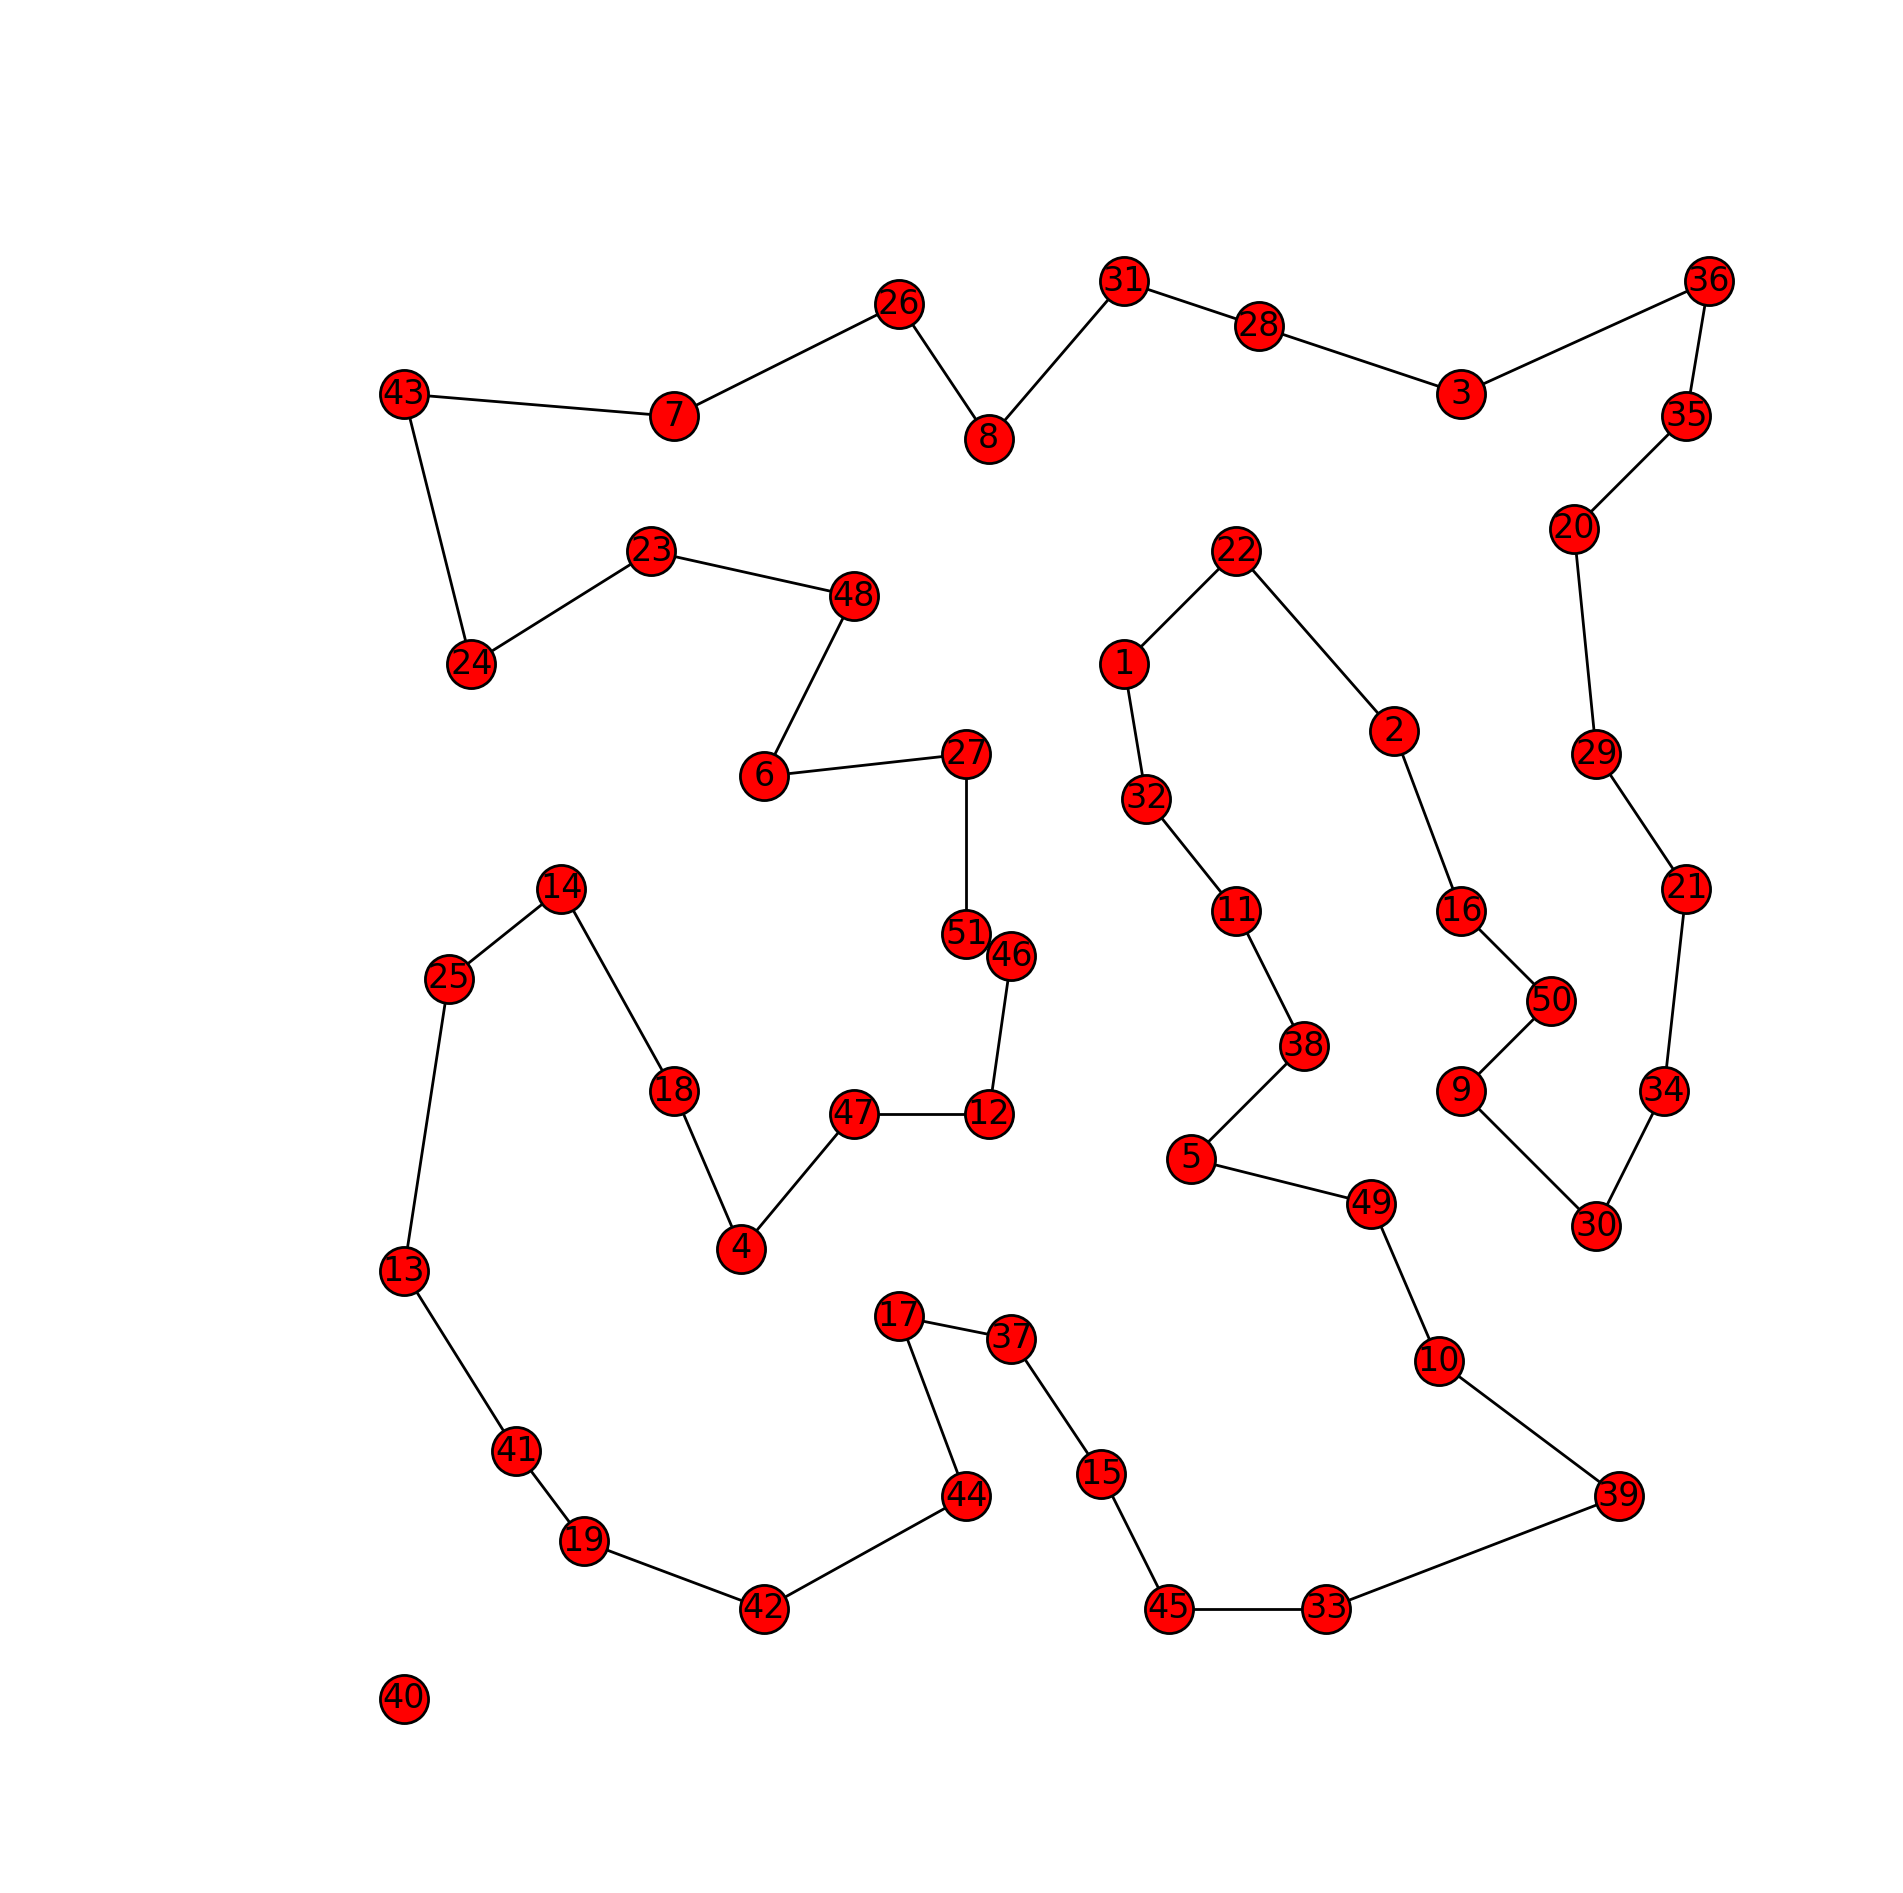

In [13]:
print("Instance: ")
print("eil" + str(N) + "-" + str(dataset))
print()

print("Best Objective Value:")
print("%.2f" %calculateObj(bestRoute))
print()

print("Number of Customers Visited (Depot Excluded):")
print(len(bestRoute)-2)
print()

print("Sequence of Customers Visited:")
print(bestRoute)
print()

print("CPU Time (s):")
timePassed = (t2-t1)
print("%.2f" %timePassed)

%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(9,9))

G=nx.Graph()

for lab, row in df.iterrows():
    G.add_node(lab, pos = (row['x'], row['y']))

for i in range(1,len(bestRoute)):
    G.add_edge(bestRoute[i-1], bestRoute[i])
    
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos,with_labels = True)

plt.show()

## 2-opt Visualization

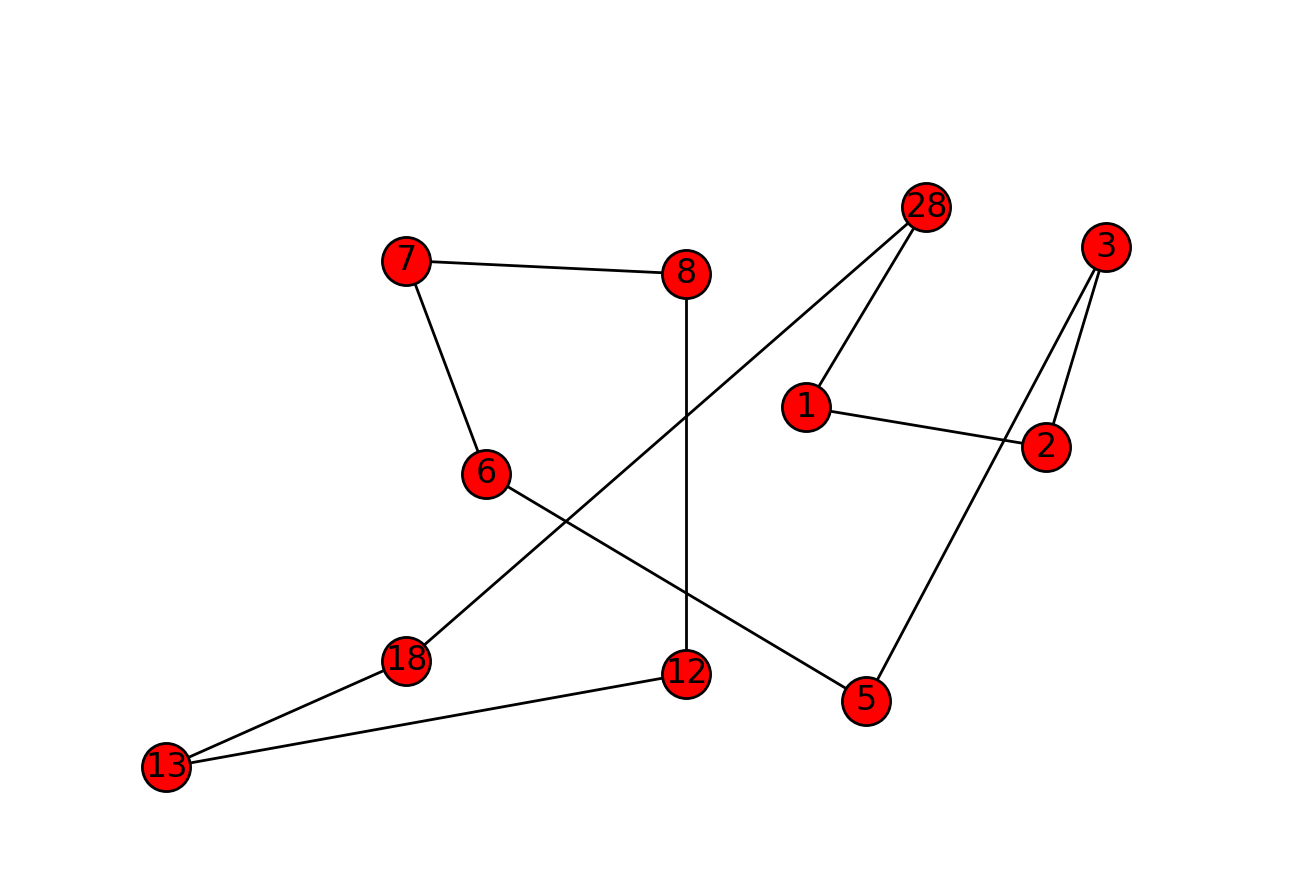

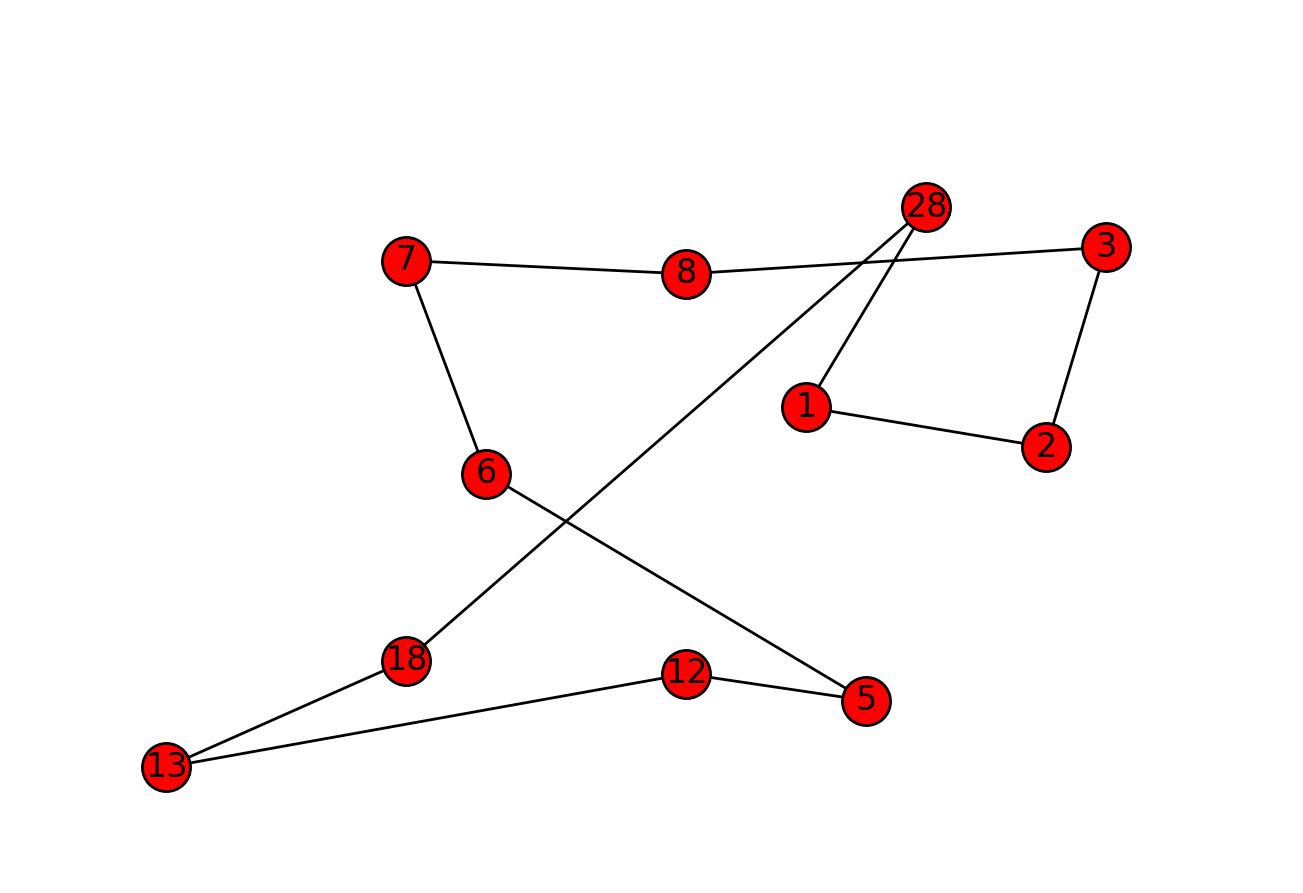

3,5 - 8,12


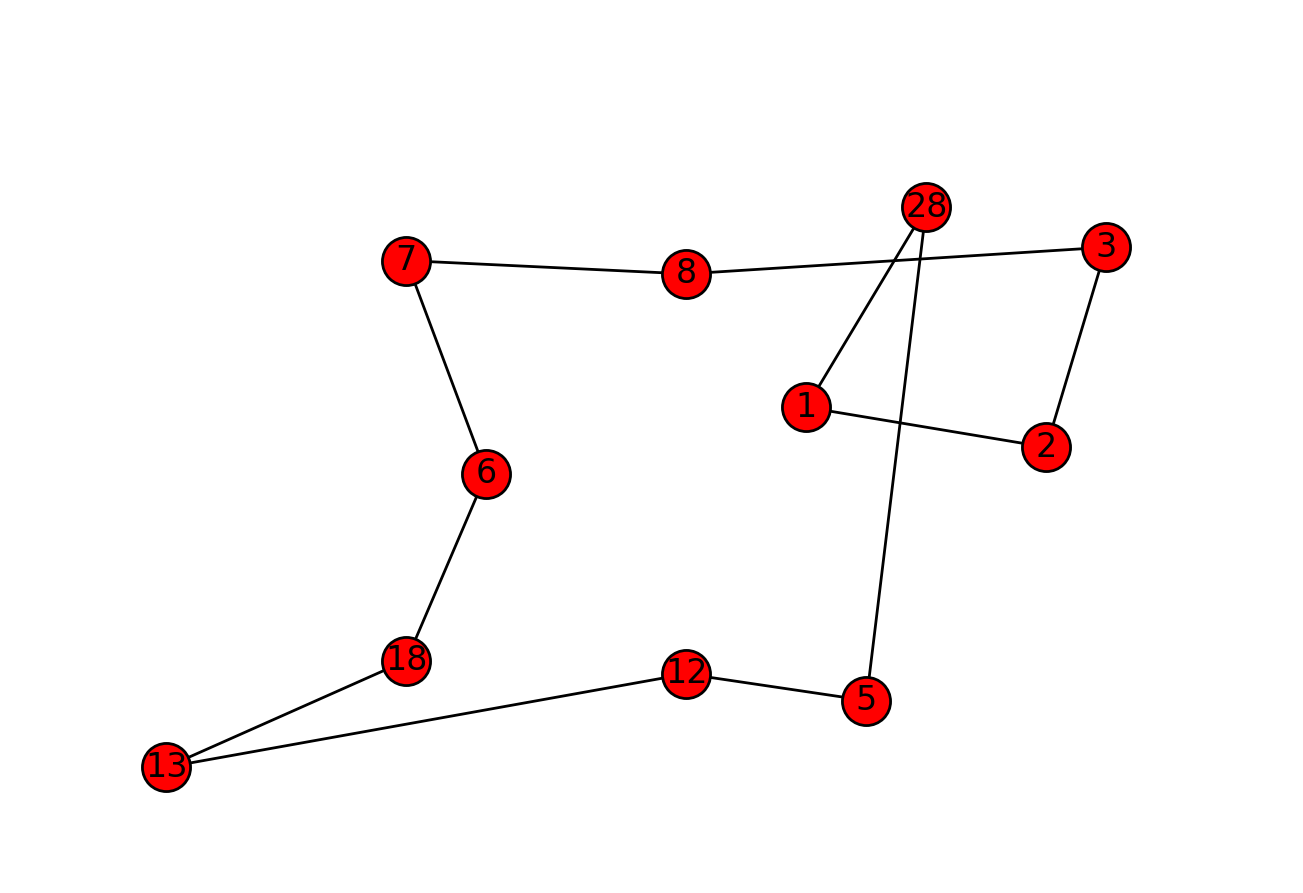

6,5 - 18,28


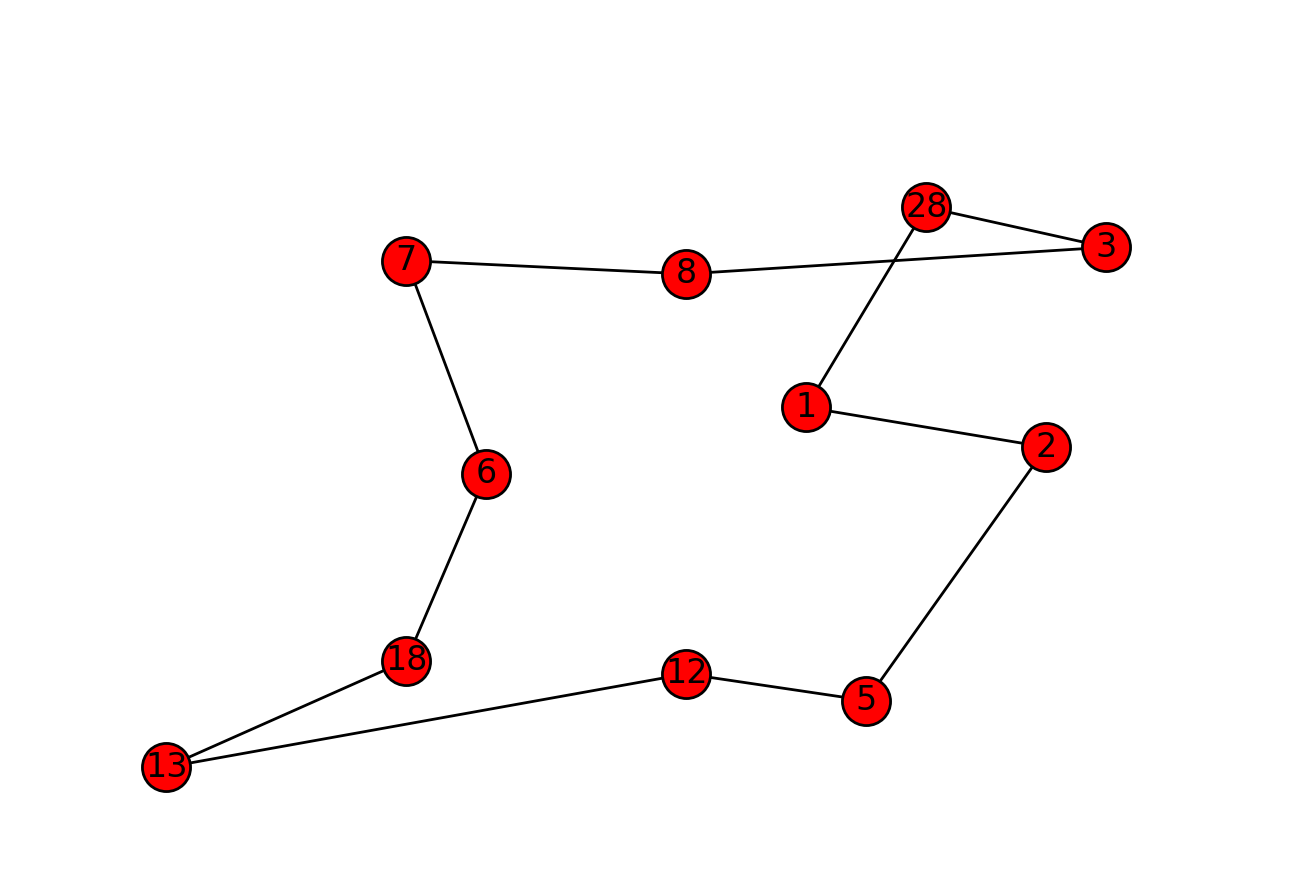

2,3 - 5,28


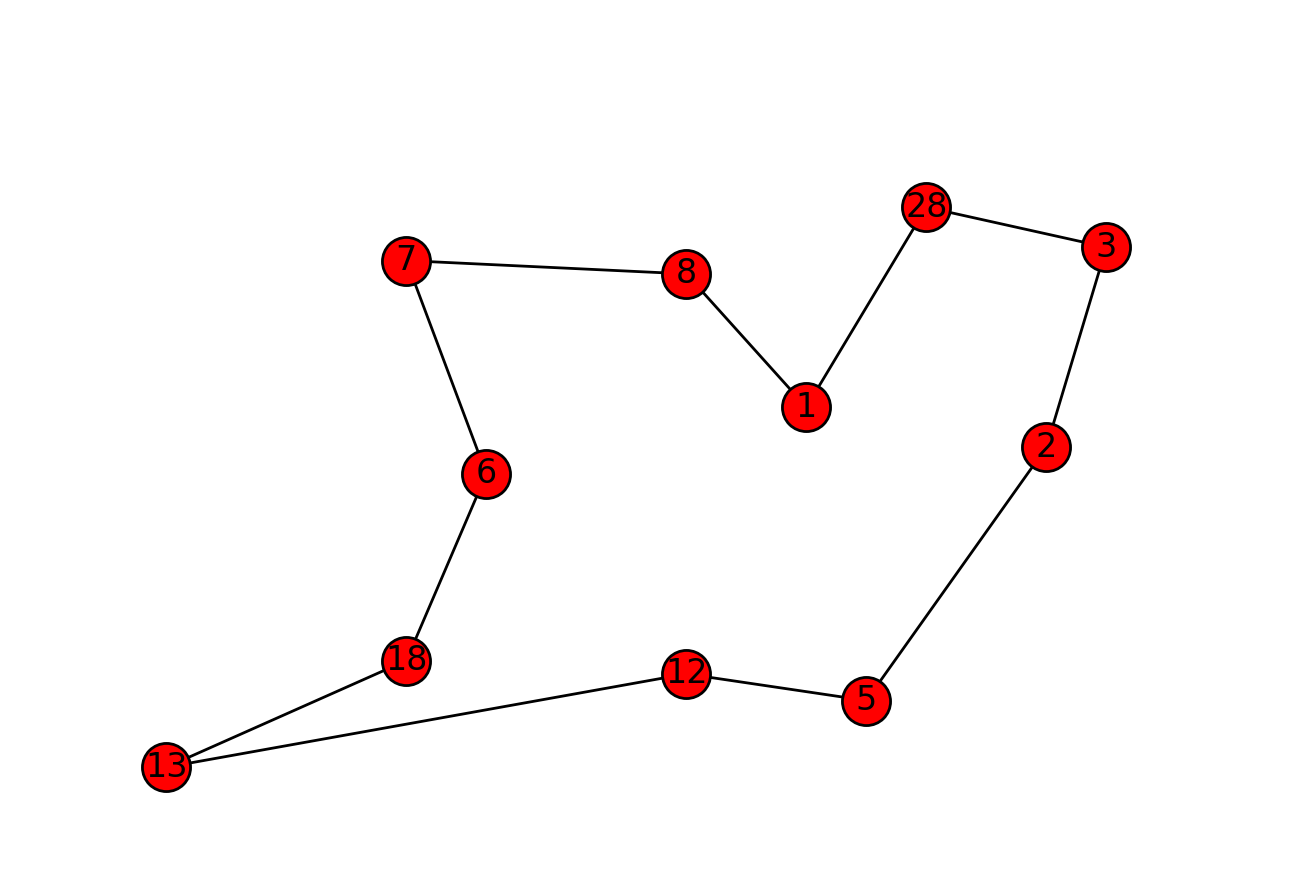

1,2 - 8,3


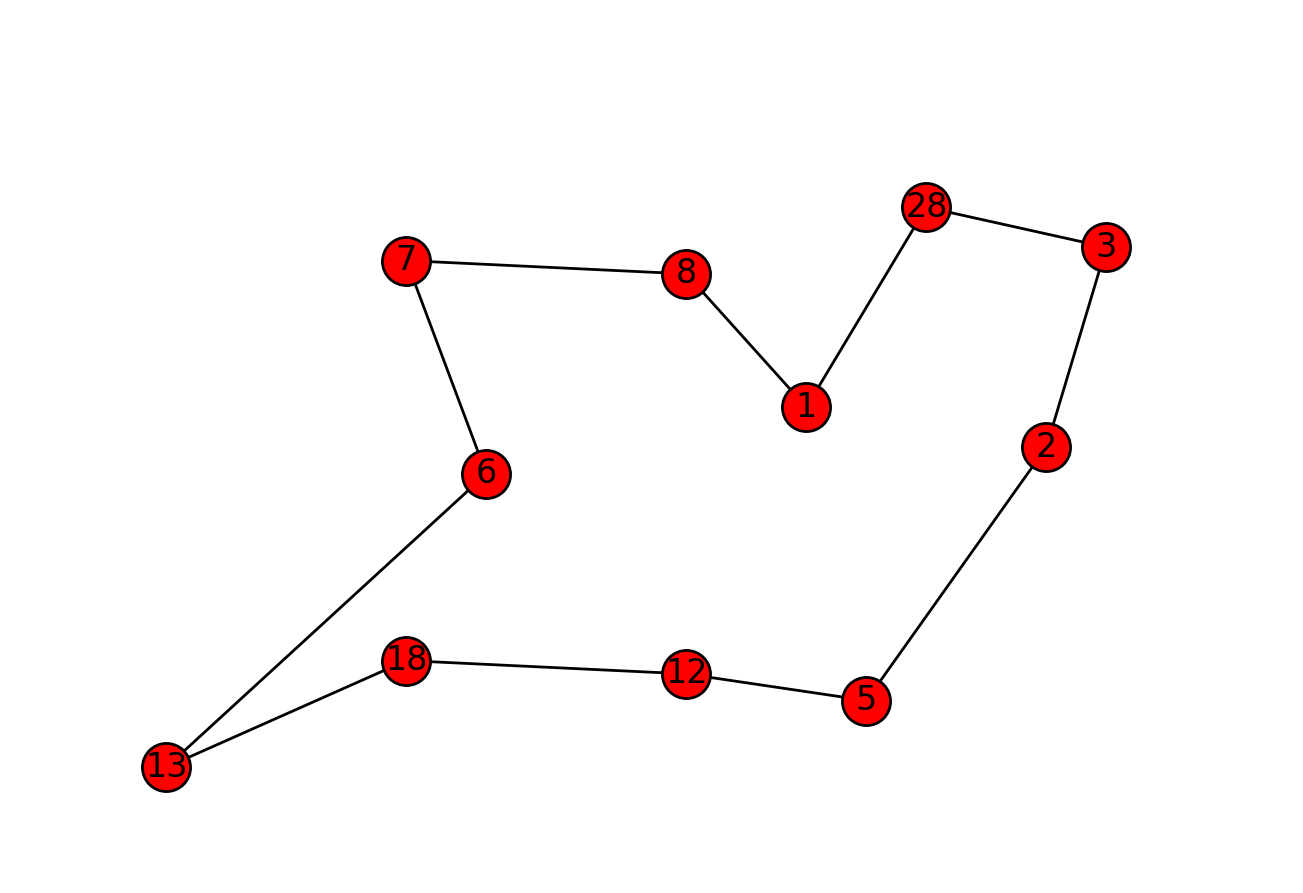

6,18 - 13,12


In [38]:
path = [1,2,3,5,6,7,8,12,13,18,28,1]

G=nx.Graph()

for lab, row in df.iterrows():
    if lab in path:
        G.add_node(lab, pos = (row['x'], row['y']))

for i in range(1,len(path)):
    G.add_edge(path[i-1], path[i])
    
pos=nx.get_node_attributes(G,'pos')

path, G = twoOpt(path, G, True)